# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 128, 32]):
    """
    Build your own model
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
"""
Set your required experiment parameters
"""
def optimizer_chooser(name='Adam', lr=1e-2):
    optimizer = {'SGD': keras.optimizers.SGD(lr=lr, nesterov=True, momentum=0.9), 
                 'RMSprop': keras.optimizers.RMSprop(lr=lr),
                 'Adagrad': keras.optimizers.Adagrad(lr=lr), 
                 'Adam': keras.optimizers.Adam(lr=lr)}
    return optimizer[name]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adam']
learning_rate = [1e-2, 1e-3]
epochs = 50
batch_size = 256


In [8]:
results = {}
"""
建立你的訓練與實驗迴圈並蒐集資料
"""
for opt in optimizer:
    for lr in learning_rate:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print(f'optimizer = {opt}, learning_rate = {lr}')
        model = build_mlp(input_shape=x_train.shape[1:])
        model.summary()
        optimizer_choosed = optimizer_chooser(name=opt, lr=lr)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer_choosed)

        model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]

        name_tag = f'optimizer = {opt}, learning_rate = {lr}'
        results[name_tag] = {'train-loss': train_loss, 'valid-loss': valid_loss, 
                             'train-acc': train_acc, 'valid-acc': valid_acc}

optimizer = SGD, learning_rate = 0.01
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               65664     
_________________________________________________________________
hidden_layer3 (Dense)        (None, 32)                4128      
_________________________________________________________________
output (Dense)               (None, 10)                330       
Total params: 1,643,498
Trainable params: 1,643,498
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [===

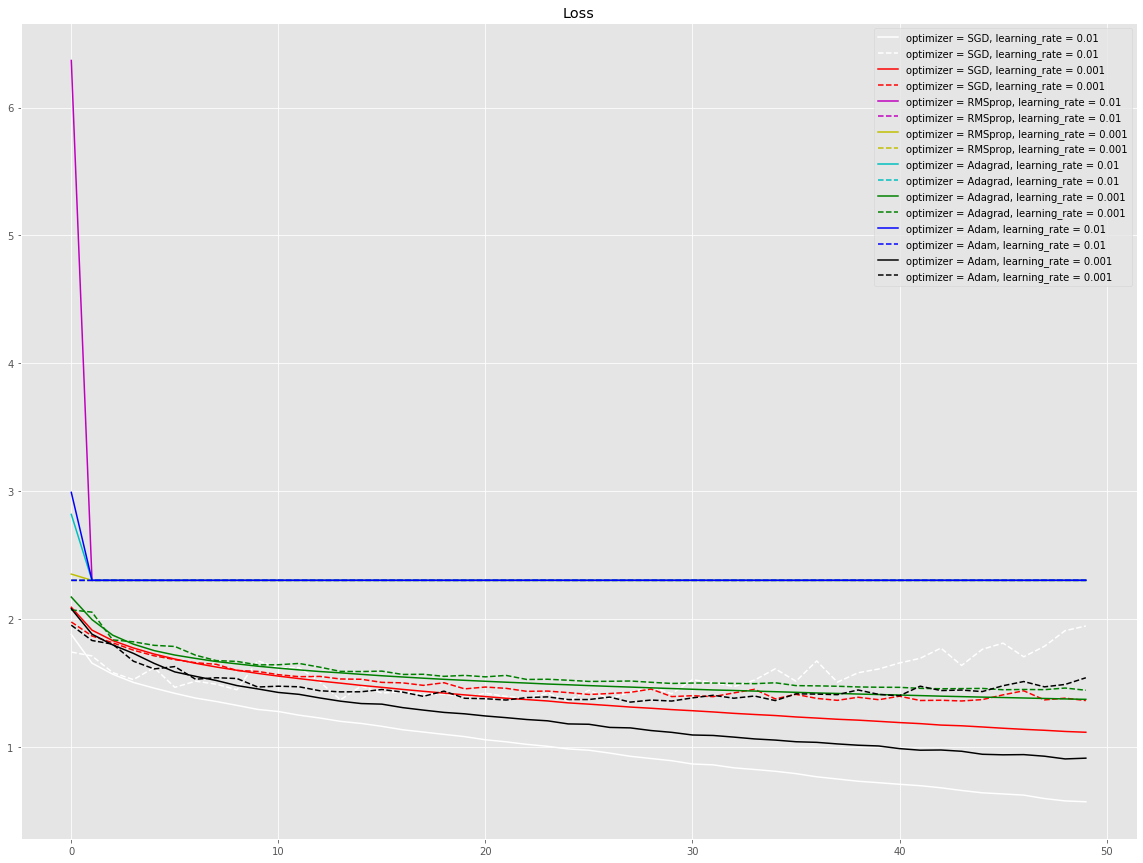

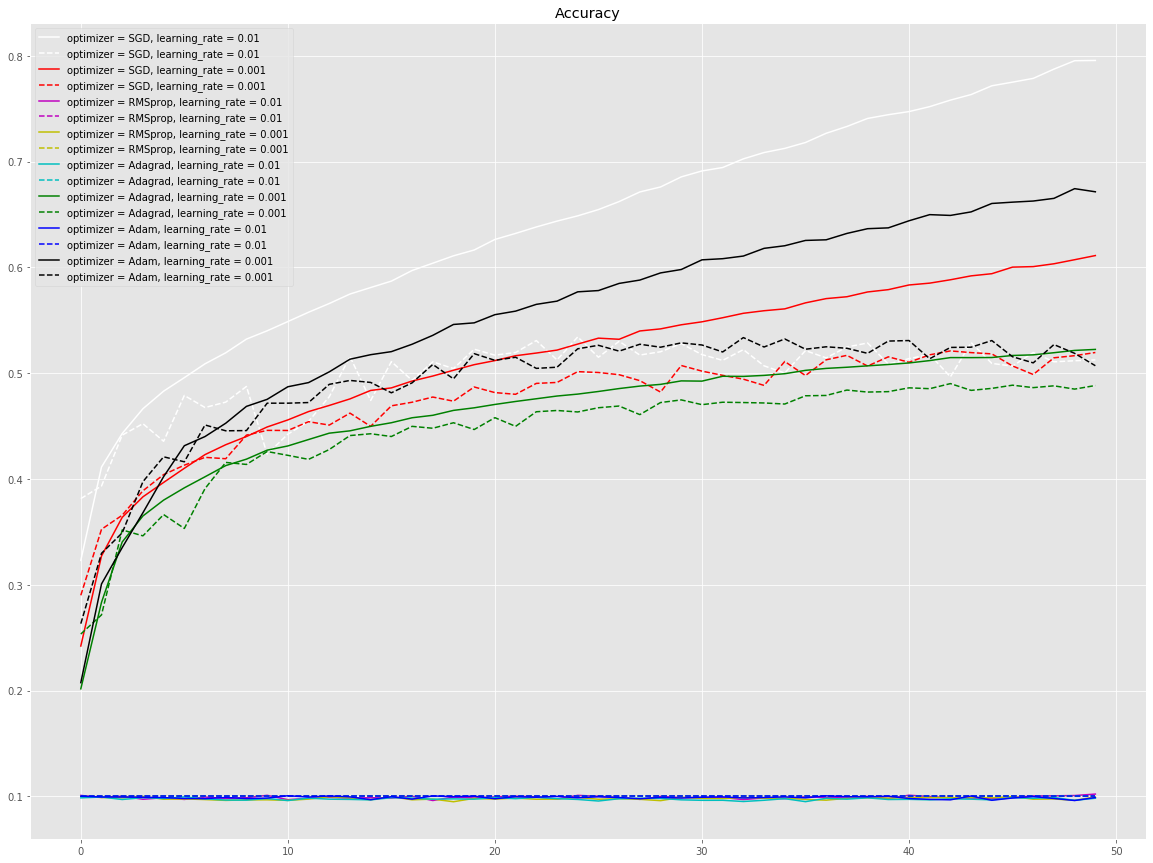

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
"""
將實驗結果繪出
"""
plt.style.use('ggplot')
color_bar = ['w', "r", "m", "y" ,'c', "g", "b", "k"]

plt.figure(figsize=(20, 15))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(20, 15))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()